In [80]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
from itertools import combinations, compress, product
import csv
import datetime
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.api as sm
import random
from numpyencoder import NumpyEncoder
from sklearn.neighbors.kde import KernelDensity
import math
import cvxpy as cp

In [81]:
with open('../recomb_ihart.ms2/gene_conversions.json', 'r') as f:
    crossovers = json.load(f)

In [82]:
with open('../recomb_ihart.ms2/sibpairs.json', 'r') as f:
    sibpairs = json.load(f)

In [83]:
ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if 'ssc' in ped_file:
                child_id = child_id.replace('.', '_')
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex


print('ped loaded')
print('children', len(child_id_to_affected))




ped loaded
children 2635


In [99]:
chroms = sorted(set([x['chrom'] for x in crossovers]))
chrom_mat_to_index = dict([(x, i) for i, x in enumerate(chroms)])

In [100]:

X = np.zeros((len(sibpairs), len(chroms)))
sibpair_to_index = dict([((x['sibling2'], x['sibling1']), i) for i, x in enumerate(sibpairs)])
for co in crossovers:
    X[sibpair_to_index[tuple(co['child'])], chrom_mat_to_index[co['chrom']]] += 1
    
X = sm.add_constant(X)

In [101]:
num_aff = np.array([int(child_id_to_affected[x['sibling1']]=='2')+int(child_id_to_affected[x['sibling2']]=='2') for x in sibpairs])
num_male = np.array([int(child_id_to_sex[x['sibling1']]=='1')+int(child_id_to_sex[x['sibling2']]=='1') for x in sibpairs])


In [104]:
indices = ((num_aff==2) | (num_aff==1)) & (num_male==2)
model = sm.Logit(num_aff[indices]==2, X[indices, :])
results = model.fit()
model.exog_names[:] = ['const'] + chroms
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.637197
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  935
Model:                          Logit   Df Residuals:                      911
Method:                           MLE   Df Model:                           23
Date:                Thu, 24 Mar 2022   Pseudo R-squ.:                 0.01354
Time:                        16:04:37   Log-Likelihood:                -595.78
converged:                       True   LL-Null:                       -603.96
Covariance Type:            nonrobust   LLR p-value:                    0.8396
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9846      0.264      3.724      0.000       0.466       1.503
1             -0.0291      0.

In [ ]:
indices = (num_aff==2) | (num_aff==1)
model = sm.Logit(num_aff[indices]==2, X[indices, :])
results = model.fit()
model.exog_names[:] = ['const'] + chroms
print(results.summary())

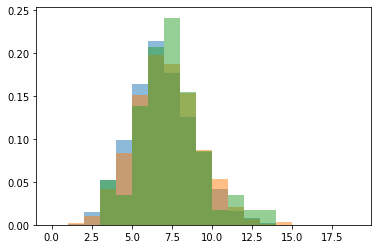

6.0 7.0 7.0


In [72]:
bins = np.arange(0, 20, 1)

plt.hist(X[num_aff==2, 3], alpha=0.5, bins=bins, density=True)
plt.hist(X[num_aff==1, 3], alpha=0.5, bins=bins, density=True)
plt.hist(X[num_aff==0, 3], alpha=0.5, bins=bins, density=True)
plt.show()

print(np.median(X[num_aff==2, 3]), np.median(X[num_aff==1, 3]), np.median(X[num_aff==0, 3]))

In [26]:
print(X)

[[ 1. 43. 77.]
 [ 1. 56. 90.]
 [ 1. 45. 65.]
 ...
 [ 1. 49. 77.]
 [ 1. 58. 66.]
 [ 1. 60. 86.]]
